# Citations by geography
In this notebook, we'll look at the dyadic citation frequencies by continent, as well as plot citations on the map by country.

In [1]:
import networkx as nx
from collections import defaultdict
import plotly.express as px
import pandas as pd
import geopandas as gpd
import numpy as np
from functools import reduce
import pycountry_convert as pc
import sys
sys.path.append('../desiccation_network/conference_recommendation')
import utils
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from collections import defaultdict
import seaborn as sns
import pandas as pd
import jsonlines
from math import ceil
plt.rcParams['pdf.fonttype'] = 42

## Read in data

In [2]:
geo_graph = nx.read_graphml('../data/citation_network/FINAL_FINAL_DEBUGGED_MANUALLY_VERIFIED_core_collection_destol_or_anhydro_classified_network_29Mar2024_with_geography.graphml')

In [30]:
with jsonlines.open('../data/wos_files/core_collection_destol_or_anhydro_ALL_with_authors_and_addresses_14Feb2024.jsonl') as reader:
    data = [obj for obj in reader]

## Pre-process data

First, we need to pre-process the data to get the number of citations from each country to each other country, and each continent to each other continent.

Start by sorting nodes into countries and continents:

In [4]:
country_nodes = defaultdict(list)
continent_nodes = defaultdict(list)
for node, data in geo_graph.nodes(data=True):
    country_nodes[data['country']].append(node)
    continent_nodes[data['continent']].append(node)

To work with this data, for each of country and continent, we'll treat the data like a graph, where nodes are country/continent, edges are citations from one country/continent to another, and the weight is how often that happens. So we need a container for edges, that for each country/continent pair, augments the weight counter for that edge every time we encounter it.

In [5]:
country_edge_weights = defaultdict(int)
country_attrs = nx.get_node_attributes(geo_graph, 'country')
for country, nodes in country_nodes.items():
    for node in nodes:
        for cited in geo_graph.out_edges(node):
            country_edge_weights[(country, country_attrs[cited[1]])] += 1

In [6]:
continent_edge_weights = defaultdict(int)
continent_attrs = nx.get_node_attributes(geo_graph, 'continent')
for continent, nodes in continent_nodes.items():
    for node in nodes:
        for cited in geo_graph.out_edges(node):
            continent_edge_weights[(continent, continent_attrs[cited[1]])] += 1

Now, we want to normalize the edge weights so that they're between 0 and 1:

In [7]:
total_country_count = sum(country_edge_weights.values())
total_continent_count = sum(continent_edge_weights.values())

In [8]:
normed_country_edge_weights = {k: v/total_country_count for k, v in country_edge_weights.items()}
normed_continent_edge_weights = {k: v/total_continent_count for k, v in continent_edge_weights.items()}

We also want to size the points on each country/continent by the relative number of papers that come from that country/continent, so let's get those counts here:

In [9]:
country_paper_count = defaultdict(int)
continent_paper_count = defaultdict(int)
for node, data in geo_graph.nodes(data=True):
    country_paper_count[data['country']] += 1
    continent_paper_count[data['continent']] += 1

In [10]:
normed_country_paper_count = {k: v/sum(country_paper_count.values()) for k, v in country_paper_count.items()}
normed_continent_paper_count = {k: v/sum(continent_paper_count.values()) for k, v in continent_paper_count.items()}

Finally, we want to define a mapping between each country and its continent so we can color the arrows in our plots accordingly:

In [11]:
country2continent = {
    attrs['country'] : attrs['continent']
    for node, attrs in geo_graph.nodes(data=True)
}

## Dyadic citation plots
We'll make the same graph figures that we made for the study systems.

In [12]:
continent_dyads = utils.calculate_dyadic_citation_freqs(geo_graph, 'continent')
continent_dyads

{('Africa', 'Africa'): 0.22376311844077962,
 ('Africa', 'Asia'): 0.056596701649175414,
 ('Africa', 'Oceania'): 0.034857571214392806,
 ('Africa', 'No continent'): 0.35082458770614694,
 ('Africa', 'South America'): 0.008620689655172414,
 ('Africa', 'Europe'): 0.20727136431784107,
 ('Africa', 'North America'): 0.11806596701649176,
 ('Asia', 'Africa'): 0.046887268648345484,
 ('Asia', 'Asia'): 0.24083006169377455,
 ('Asia', 'Oceania'): 0.01962983735277622,
 ('Asia', 'No continent'): 0.2759394279304543,
 ('Asia', 'South America'): 0.01862030286034773,
 ('Asia', 'Europe'): 0.24150308468872686,
 ('Asia', 'North America'): 0.15659001682557488,
 ('Oceania', 'Africa'): 0.06976744186046512,
 ('Oceania', 'Asia'): 0.06708407871198568,
 ('Oceania', 'Oceania'): 0.13148479427549195,
 ('Oceania', 'No continent'): 0.33094812164579607,
 ('Oceania', 'South America'): 0.008944543828264758,
 ('Oceania', 'Europe'): 0.24329159212880144,
 ('Oceania', 'North America'): 0.148479427549195,
 ('No continent', 'Afric

In [13]:
colors = {'Europe': '#e28bff', 'Asia': '#69c404', 'North America': '#28d0ff', 'South America': '#ffa550',
         'Africa': '#ff5d85', 'Oceania': '#049c79', 'No continent': '#a5a5a5'}

In [14]:
nodes = list(set([k[0] for k in continent_dyads.keys()]))
nodes = [(n, {'color': colors[n]}) for n in nodes]
nodes

[('Africa', {'color': '#ff5d85'}),
 ('Asia', {'color': '#69c404'}),
 ('Oceania', {'color': '#049c79'}),
 ('No continent', {'color': '#a5a5a5'}),
 ('South America', {'color': '#ffa550'}),
 ('Europe', {'color': '#e28bff'}),
 ('North America', {'color': '#28d0ff'})]

In [15]:
edges = [(k[0], k[1], {'weight': round(v, 2)*10, 'color': colors[k[0]]}) for k, v in continent_dyads.items()]
edges[:5]

[('Africa', 'Africa', {'weight': 2.2, 'color': '#ff5d85'}),
 ('Africa', 'Asia', {'weight': 0.6, 'color': '#ff5d85'}),
 ('Africa', 'Oceania', {'weight': 0.3, 'color': '#ff5d85'}),
 ('Africa', 'No continent', {'weight': 3.5, 'color': '#ff5d85'}),
 ('Africa', 'South America', {'weight': 0.1, 'color': '#ff5d85'})]

In [16]:
dyadic_freq_graph = nx.MultiDiGraph()
_ = dyadic_freq_graph.add_nodes_from(nodes)
_ = dyadic_freq_graph.add_edges_from(edges)

In [17]:
class SelfLoop():
    def __init__(self, v_scale=0.25, h_scale=0.25, nodesize=100):
        self.v_scale = v_scale
        self.h_scale = h_scale
        self.nodesize = nodesize

    def selfloopstyle(self, posA, posB, *args, **kwargs):
        from matplotlib.path import Path

        selfloop_ht = 0.005 * self.nodesize

        data_loc = ax.transData.inverted().transform(posA)
        v_shift = self.v_scale * selfloop_ht
        h_shift = v_shift * self.h_scale

        path = [
            data_loc + np.asarray([0, v_shift]),
            data_loc + np.asarray([h_shift, v_shift]),
            data_loc + np.asarray([h_shift, 0]),
            data_loc,
            data_loc + np.asarray([-h_shift, 0]),
            data_loc + np.asarray([-h_shift, v_shift]),
            data_loc + np.asarray([0, v_shift]),
        ]

        ret = Path(ax.transData.transform(path), [1, 4, 4, 4, 4, 4, 4])

        return ret
    
    def style(self):
        return self.selfloopstyle

/tmp/local/34970136/ipykernel_22908/1746413807.py:14: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  e = nx.draw_networkx_edges(dyadic_freq_graph, pos, width=edge_weights, edge_color=edge_colors, connectionstyle='arc3, rad = 0.1', node_size=nodesize)


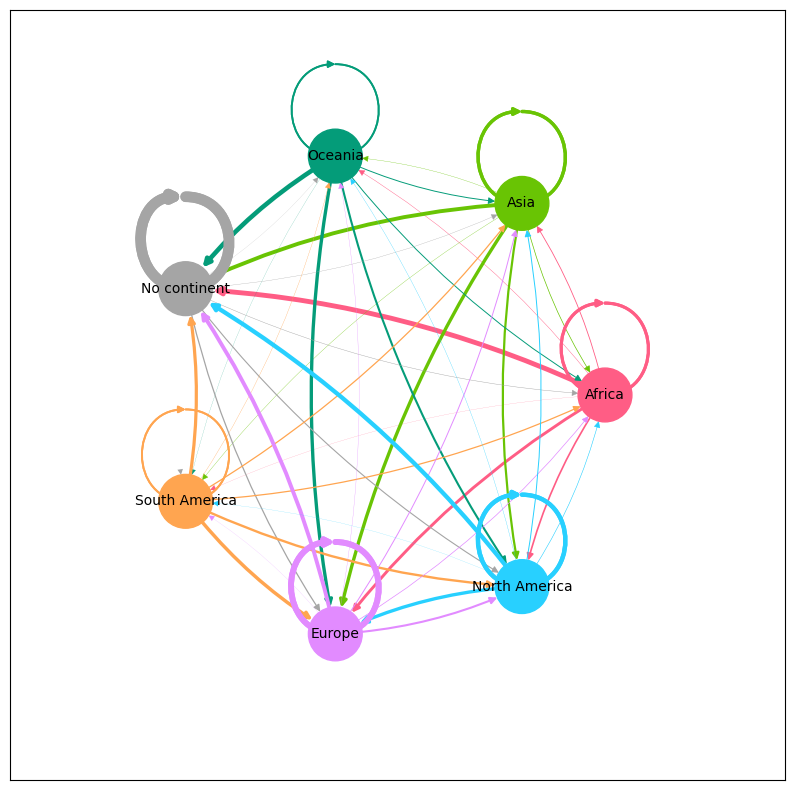

In [18]:
nodes = dyadic_freq_graph.nodes(data=True)
node_colors = [attrs['color'] for n, attrs in nodes]
edges = dyadic_freq_graph.edges(data=True)
edge_colors = [attrs['color'] for e1, e2, attrs in edges]
edge_weights = [attrs['weight'] for e1, e2, attrs in edges]

pos = nx.circular_layout(dyadic_freq_graph)
fig, ax = plt.subplots(figsize=(10,10))
plt.margins(x=0.2)

nodesize=1500
nx.draw_networkx_nodes(dyadic_freq_graph, pos, node_size=nodesize, node_color=node_colors)
_ = nx.draw_networkx_labels(dyadic_freq_graph, pos, font_size=10, font_family="sans-serif")
e = nx.draw_networkx_edges(dyadic_freq_graph, pos, width=edge_weights, edge_color=edge_colors, connectionstyle='arc3, rad = 0.1', node_size=nodesize)

ax.set_xlim([1.2*x for x in ax.get_xlim()])
ax.set_ylim([1.2*y for y in ax.get_ylim()])

horiz = 0.7
vert = 0.05
for i, edge in enumerate(edges):
    if edge[0] == edge[1]:
        e[i]._connector = SelfLoop(vert, horiz, nodesize=nodesize).style() #select self loop and change connector
        ax.add_patch(e[i]) #add the patch to ax

Unfortunately, the no-continent papers have a heavy impact on this anlaysis; what happens if we leave them out, the same way we exclude NOCLASS papers when we look at study system?

In [19]:
to_remove = [n for n, attrs in geo_graph.nodes(data=True) if attrs['continent'] == 'No continent']
_ = geo_graph.remove_nodes_from(to_remove)

In [20]:
continent_dyads = utils.calculate_dyadic_citation_freqs(geo_graph, 'continent')
continent_dyads

{('Africa', 'Africa'): 0.3446882217090069,
 ('Africa', 'Asia'): 0.08718244803695151,
 ('Africa', 'Oceania'): 0.05369515011547344,
 ('Africa', 'South America'): 0.013279445727482679,
 ('Africa', 'Europe'): 0.31928406466512704,
 ('Africa', 'North America'): 0.18187066974595842,
 ('Asia', 'Africa'): 0.06475600309837336,
 ('Asia', 'Asia'): 0.33261037955073586,
 ('Asia', 'Oceania'): 0.027110766847405113,
 ('Asia', 'South America'): 0.025716498838109992,
 ('Asia', 'Europe'): 0.3335398915569326,
 ('Asia', 'North America'): 0.21626646010844305,
 ('Oceania', 'Africa'): 0.10427807486631016,
 ('Oceania', 'Asia'): 0.10026737967914438,
 ('Oceania', 'Oceania'): 0.196524064171123,
 ('Oceania', 'South America'): 0.013368983957219251,
 ('Oceania', 'Europe'): 0.36363636363636365,
 ('Oceania', 'North America'): 0.22192513368983957,
 ('South America', 'Africa'): 0.12178702570379436,
 ('South America', 'Asia'): 0.1211750305997552,
 ('South America', 'Oceania'): 0.03182374541003672,
 ('South America', 'Sout

In [21]:
nodes = list(set([k[0] for k in continent_dyads.keys()]))
nodes = [(n, {'color': colors[n]}) for n in nodes]
nodes

[('Africa', {'color': '#ff5d85'}),
 ('Asia', {'color': '#69c404'}),
 ('Oceania', {'color': '#049c79'}),
 ('South America', {'color': '#ffa550'}),
 ('Europe', {'color': '#e28bff'}),
 ('North America', {'color': '#28d0ff'})]

In [22]:
edges = [(k[0], k[1], {'weight': round(v, 2)*10, 'color': colors[k[0]]}) for k, v in continent_dyads.items()]
edges[:5]

[('Africa', 'Africa', {'weight': 3.4000000000000004, 'color': '#ff5d85'}),
 ('Africa', 'Asia', {'weight': 0.8999999999999999, 'color': '#ff5d85'}),
 ('Africa', 'Oceania', {'weight': 0.5, 'color': '#ff5d85'}),
 ('Africa', 'South America', {'weight': 0.1, 'color': '#ff5d85'}),
 ('Africa', 'Europe', {'weight': 3.2, 'color': '#ff5d85'})]

In [23]:
dyadic_freq_graph = nx.MultiDiGraph()
_ = dyadic_freq_graph.add_nodes_from(nodes)
_ = dyadic_freq_graph.add_edges_from(edges)

/tmp/local/34970136/ipykernel_22908/4139334992.py:14: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  e = nx.draw_networkx_edges(dyadic_freq_graph, pos, width=edge_weights, edge_color=edge_colors, connectionstyle='arc3, rad = 0.1', node_size=nodesize)


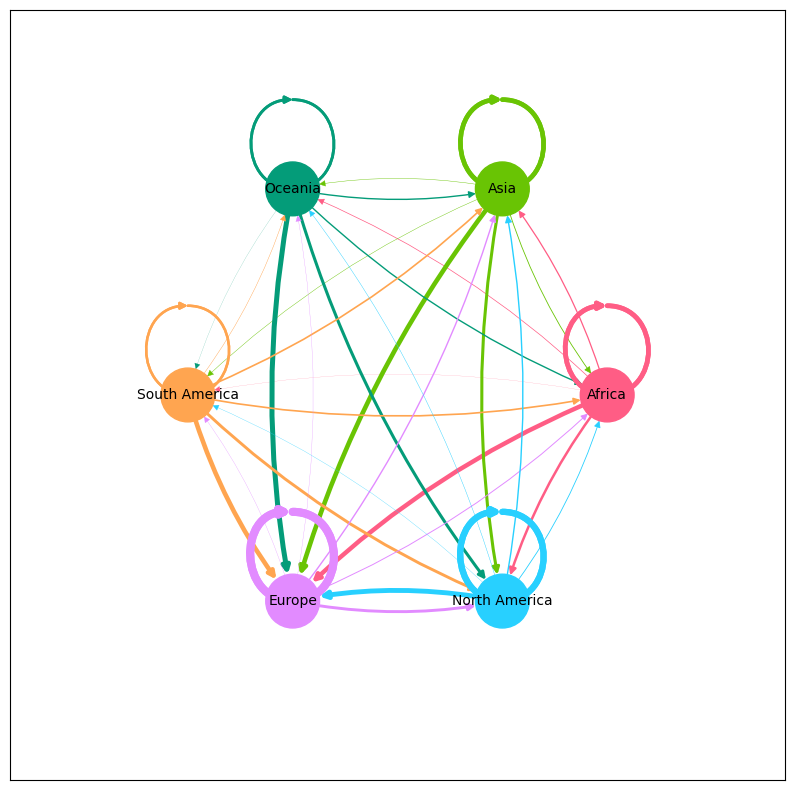

In [25]:
nodes = dyadic_freq_graph.nodes(data=True)
node_colors = [attrs['color'] for n, attrs in nodes]
edges = dyadic_freq_graph.edges(data=True)
edge_colors = [attrs['color'] for e1, e2, attrs in edges]
edge_weights = [attrs['weight'] for e1, e2, attrs in edges]

pos = nx.circular_layout(dyadic_freq_graph)
fig, ax = plt.subplots(figsize=(10,10))
plt.margins(x=0.2)

nodesize=1500
nx.draw_networkx_nodes(dyadic_freq_graph, pos, node_size=nodesize, node_color=node_colors)
_ = nx.draw_networkx_labels(dyadic_freq_graph, pos, font_size=10, font_family="sans-serif")
e = nx.draw_networkx_edges(dyadic_freq_graph, pos, width=edge_weights, edge_color=edge_colors, connectionstyle='arc3, rad = 0.1', node_size=nodesize)

ax.set_xlim([1.2*x for x in ax.get_xlim()])
ax.set_ylim([1.2*y for y in ax.get_ylim()])

horiz = 0.7
vert = 0.05
for i, edge in enumerate(edges):
    if edge[0] == edge[1]:
        e[i]._connector = SelfLoop(vert, horiz, nodesize=nodesize).style() #select self loop and change connector
        ax.add_patch(e[i]) #add the patch to ax
plt.savefig('../data/citation_network/figures/fig_6B.pdf', format='pdf', bbox_inches='tight', dpi=600)

Quick bar plot of the portions of the dataset made up by each discipline:

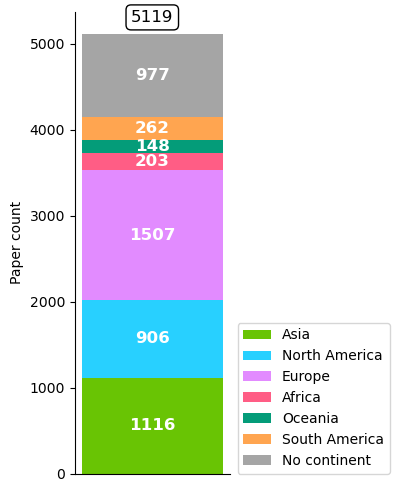

In [26]:
per_continent_pubs = defaultdict(int)
for n, attr in geo_graph.nodes(data=True):
    per_continent_pubs[attr['continent']] += 1
per_continent_pubs['No continent'] = len(to_remove)

# Plot
bottom = np.zeros(1)
fig, ax = plt.subplots(figsize=(2,6))
for cont, papers in per_continent_pubs.items():
    ax.bar('Dataset', papers, color=colors[cont], label=cont, bottom=bottom)
    bottom += papers
    
for bar in ax.patches:
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        0.5*bar.get_height() + bar.get_y(),
        int(bar.get_height()),
        ha='center',
        va='center',
        color='w',
        weight='bold',
        size=12
    )
    
    centered_x = bar.get_x() + bar.get_width() / 2
    top_y = bar.get_height() + bar.get_y()

ax.text(centered_x, top_y + 100, sum(per_continent_pubs.values()), bbox={'boxstyle':'round', 'facecolor':'w'}, ha='center', va='bottom', fontsize=12)
ax.set_ylabel('Paper count')
ax.spines[['right', 'top']].set_visible(False)
ax.get_xaxis().set_visible(False)
plt.legend(loc=(1.05,0))
plt.savefig('../data/citation_network/figures/fig_6C.pdf', format='pdf', dpi=600, bbox_inches='tight')

Subset to only plants to see how that affects the citation dynamics:

In [62]:
non_plants = [n for n, attrs in geo_graph.nodes(data=True) if attrs['study_system'] != 'Plant']
_ = geo_graph.remove_nodes_from(non_plants)

In [63]:
plant_continent_dyads = utils.calculate_dyadic_citation_freqs(geo_graph, 'continent')
plant_continent_dyads

{('Asia', 'Asia'): 0.2924107142857143,
 ('Asia', 'Europe'): 0.35267857142857145,
 ('Asia', 'Oceania'): 0.026041666666666668,
 ('Asia', 'South America'): 0.031994047619047616,
 ('Asia', 'Africa'): 0.09102182539682539,
 ('Asia', 'North America'): 0.2058531746031746,
 ('Europe', 'Asia'): 0.08513640639698965,
 ('Europe', 'Europe'): 0.5617748510504861,
 ('Europe', 'Oceania'): 0.027124490435873314,
 ('Europe', 'South America'): 0.01191596111633741,
 ('Europe', 'Africa'): 0.09344622138601442,
 ('Europe', 'North America'): 0.22060206961429915,
 ('Oceania', 'Asia'): 0.10964912280701754,
 ('Oceania', 'Europe'): 0.40789473684210525,
 ('Oceania', 'Oceania'): 0.17105263157894737,
 ('Oceania', 'South America'): 0.008771929824561403,
 ('Oceania', 'Africa'): 0.10307017543859649,
 ('Oceania', 'North America'): 0.19956140350877194,
 ('South America', 'Asia'): 0.10424155283968368,
 ('South America', 'Europe'): 0.3378864126527678,
 ('South America', 'Oceania'): 0.030913012221423435,
 ('South America', 'So

In [65]:
nodes = list(set([k[0] for k in plant_continent_dyads.keys()]))
nodes = [(n, {'color': colors[n]}) for n in nodes]
nodes

[('Asia', {'color': '#69c404'}),
 ('Europe', {'color': '#e28bff'}),
 ('Oceania', {'color': '#049c79'}),
 ('South America', {'color': '#ffa550'}),
 ('Africa', {'color': '#ff5d85'}),
 ('North America', {'color': '#28d0ff'})]

In [69]:
edges = [(k[0], k[1], {'weight': round(v, 2)*10, 'color': colors[k[0]]}) for k, v in plant_continent_dyads.items()]
edges[:5]

[('Asia', 'Asia', {'weight': 2.9, 'color': '#69c404'}),
 ('Asia', 'Europe', {'weight': 3.5, 'color': '#69c404'}),
 ('Asia', 'Oceania', {'weight': 0.3, 'color': '#69c404'}),
 ('Asia', 'South America', {'weight': 0.3, 'color': '#69c404'}),
 ('Asia', 'Africa', {'weight': 0.8999999999999999, 'color': '#69c404'})]

In [70]:
dyadic_freq_graph = nx.MultiDiGraph()
_ = dyadic_freq_graph.add_nodes_from(nodes)
_ = dyadic_freq_graph.add_edges_from(edges)

/tmp/local/33335257/ipykernel_93807/191418518.py:14: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  e = nx.draw_networkx_edges(dyadic_freq_graph, pos, width=edge_weights, edge_color=edge_colors, connectionstyle='arc3, rad = 0.1', node_size=nodesize)


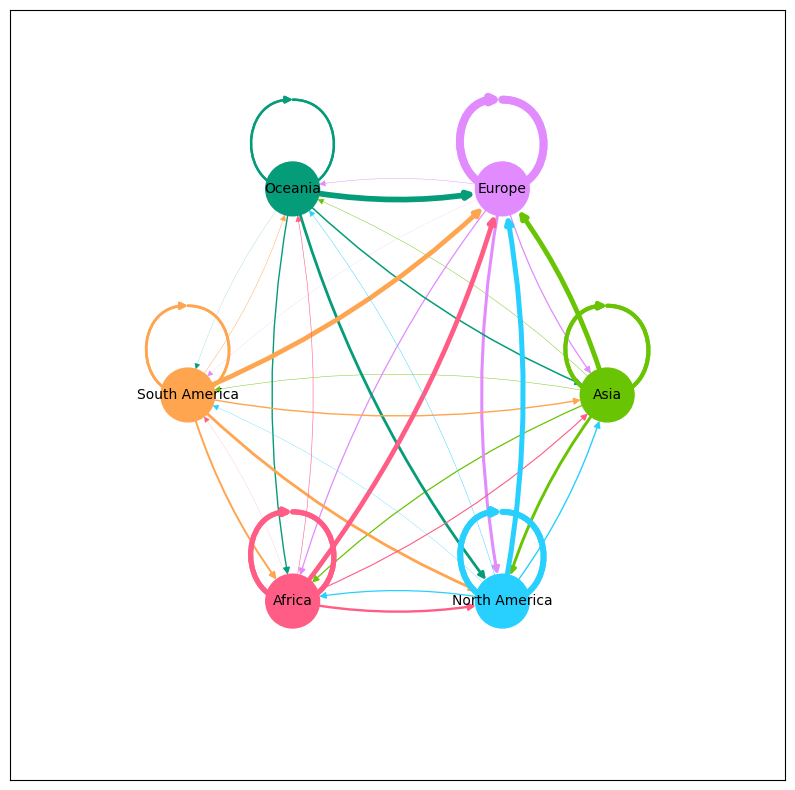

In [71]:
nodes = dyadic_freq_graph.nodes(data=True)
node_colors = [attrs['color'] for n, attrs in nodes]
edges = dyadic_freq_graph.edges(data=True)
edge_colors = [attrs['color'] for e1, e2, attrs in edges]
edge_weights = [attrs['weight'] for e1, e2, attrs in edges]

pos = nx.circular_layout(dyadic_freq_graph)
fig, ax = plt.subplots(figsize=(10,10))
plt.margins(x=0.2)

nodesize=1500
nx.draw_networkx_nodes(dyadic_freq_graph, pos, node_size=nodesize, node_color=node_colors)
_ = nx.draw_networkx_labels(dyadic_freq_graph, pos, font_size=10, font_family="sans-serif")
e = nx.draw_networkx_edges(dyadic_freq_graph, pos, width=edge_weights, edge_color=edge_colors, connectionstyle='arc3, rad = 0.1', node_size=nodesize)

ax.set_xlim([1.2*x for x in ax.get_xlim()])
ax.set_ylim([1.2*y for y in ax.get_ylim()])

horiz = 0.7
vert = 0.05
for i, edge in enumerate(edges):
    if edge[0] == edge[1]:
        e[i]._connector = SelfLoop(vert, horiz, nodesize=nodesize).style() #select self loop and change connector
        ax.add_patch(e[i]) #add the patch to ax
plt.savefig('../data/citation_network/figures/plant_only_continent_dyadic_citation_frequencies.pdf', format='pdf', bbox_inches='tight', dpi=600)

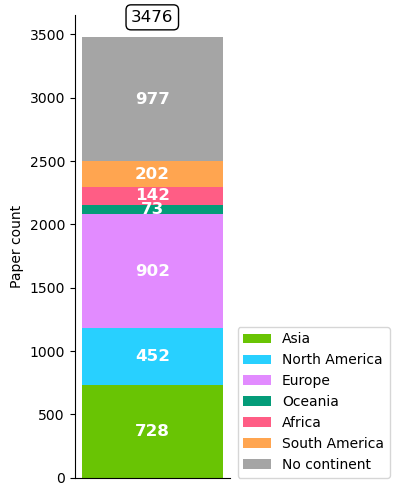

In [72]:
per_continent_pubs = defaultdict(int)
for n, attr in geo_graph.nodes(data=True):
    per_continent_pubs[attr['continent']] += 1
per_continent_pubs['No continent'] = len(to_remove)

# Plot
bottom = np.zeros(1)
fig, ax = plt.subplots(figsize=(2,6))
for cont, papers in per_continent_pubs.items():
    ax.bar('Dataset', papers, color=colors[cont], label=cont, bottom=bottom)
    bottom += papers
    
for bar in ax.patches:
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        0.5*bar.get_height() + bar.get_y(),
        int(bar.get_height()),
        ha='center',
        va='center',
        color='w',
        weight='bold',
        size=12
    )
    
    centered_x = bar.get_x() + bar.get_width() / 2
    top_y = bar.get_height() + bar.get_y()

ax.text(centered_x, top_y + 100, sum(per_continent_pubs.values()), bbox={'boxstyle':'round', 'facecolor':'w'}, ha='center', va='bottom', fontsize=12)
ax.set_ylabel('Paper count')
ax.spines[['right', 'top']].set_visible(False)
ax.get_xaxis().set_visible(False)
plt.legend(loc=(1.05,0))
plt.savefig('../data/citation_network/figures/plant_only_papers_per_continent_bar.pdf', format='pdf', dpi=600, bbox_inches='tight')

There's no real change when we subset by plants, so we'll leave this figure out of the main text of the manuscript, but leave it here in case anyone is interested.

Insularity over time, by continent:

In [27]:
geo_graph = nx.read_graphml('../data/citation_network/FINAL_FINAL_DEBUGGED_MANUALLY_VERIFIED_core_collection_destol_or_anhydro_classified_network_29Mar2024_with_geography.graphml')

In [31]:
years = {}
for paper in data:
    try:
        years[paper['UID']] = int(paper['year'])
    except KeyError:
        continue
first_dec = round(min(years.values()), -1)
last_dec = round(max(years.values()), -1)
if last_dec <= max(years.values()):
    last_dec += 10
print(f'The earliest year in our dataset is {min(years.values())}, so our first cutoff will be {first_dec}.')
print(f'The last year in our dataset is {max(years.values())}, so our last decade cutoff will be {last_dec}.')
all_decs = [first_dec + 10*i for i in range(int((last_dec/10) - (first_dec/10)) + 1)]
print(f'All decade cutoff list: {all_decs}')
year_splits = defaultdict(list)
for uid, year in years.items():
    decade = int(np.floor(year / 10) * 10)
    year_splits[decade].append(uid)

The earliest year in our dataset is 1956, so our first cutoff will be 1960.
The last year in our dataset is 2023, so our last decade cutoff will be 2030.
All decade cutoff list: [1960, 1970, 1980, 1990, 2000, 2010, 2020, 2030]


In [32]:
diff_uids = [p['UID'] for p in data if p['UID'] not in geo_graph.nodes]
dec_graphs = {}
for dec_cut in all_decs:
    all_uids = [uid for year, uids in year_splits.items() for uid in uids if (year < dec_cut) and (uid not in diff_uids)]
    print(f'There are {len(all_uids)} papers in the classified network that were published before {dec_cut}')
    if len(all_uids) > 0:
        subgraph = geo_graph.subgraph(all_uids)
        dec_graphs[dec_cut] = subgraph

There are 0 papers in the classified network that were published before 1960
There are 0 papers in the classified network that were published before 1970
There are 0 papers in the classified network that were published before 1980
There are 0 papers in the classified network that were published before 1990
There are 697 papers in the classified network that were published before 2000
There are 2053 papers in the classified network that were published before 2010
There are 4287 papers in the classified network that were published before 2020
There are 5119 papers in the classified network that were published before 2030


In [33]:
dec_freqs = {dec_cut: utils.calculate_dyadic_citation_freqs(graph, 'continent') for dec_cut, graph in dec_graphs.items()}

In [34]:
dec_freqs

{2000: {('Africa', 'Africa'): 0.031578947368421054,
  ('Africa', 'Asia'): 0.0,
  ('Africa', 'Oceania'): 0.0,
  ('Africa', 'No continent'): 0.9578947368421052,
  ('Africa', 'Europe'): 0.0,
  ('Africa', 'North America'): 0.010526315789473684,
  ('Asia', 'Africa'): 0.0,
  ('Asia', 'Asia'): 0.0,
  ('Asia', 'Oceania'): 0.0,
  ('Asia', 'No continent'): 1.0,
  ('Asia', 'Europe'): 0.0,
  ('Asia', 'North America'): 0.0,
  ('Oceania', 'Africa'): 0.0,
  ('Oceania', 'Asia'): 0.0,
  ('Oceania', 'Oceania'): 0.0,
  ('Oceania', 'No continent'): 1.0,
  ('Oceania', 'Europe'): 0.0,
  ('Oceania', 'North America'): 0.0,
  ('No continent', 'Africa'): 0.0013063357282821686,
  ('No continent', 'Asia'): 0.0013063357282821686,
  ('No continent', 'Oceania'): 0.0006531678641410843,
  ('No continent', 'No continent'): 0.984977139124755,
  ('No continent', 'Europe'): 0.0045721750489875895,
  ('No continent', 'North America'): 0.007184846505551927,
  ('Europe', 'Africa'): 0.0,
  ('Europe', 'Asia'): 0.0,
  ('Europe',

In [35]:
cont_trajectories = {}
for cont in colors.keys():
    cont_traj = []
    for year in sorted(dec_freqs.keys()):
        try:
            cont_traj.append(dec_freqs[year][(cont, cont)])
        except KeyError:
            cont_traj.append(0)
    cont_trajectories[cont] = cont_traj

In [36]:
node_attrs = nx.get_node_attributes(geo_graph, 'continent')
ppy = {}
for continent in colors.keys():
    ps = []
    for dec_cut in sorted(dec_freqs.keys()):
        all_papers = [uid for year, uids in year_splits.items() for uid in uids if (year < dec_cut) and (uid not in diff_uids)]
        all_paper_classes = {k: node_attrs[k] for k in all_papers}
        this_class_papers = [uid for uid, cont in all_paper_classes.items() if cont == continent]
        ps.append(len(this_class_papers))
    ppy[continent] = ps

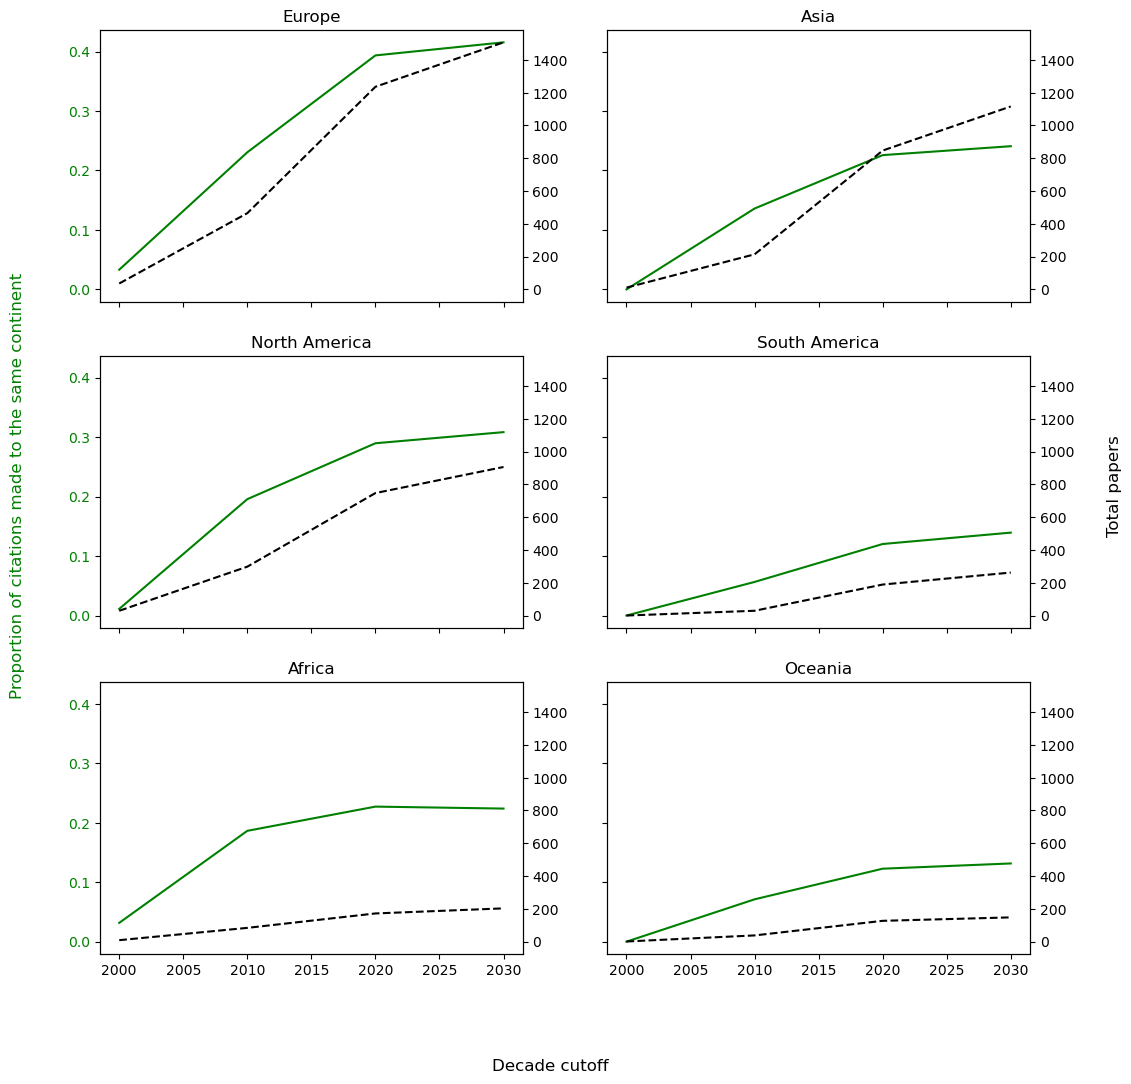

In [38]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12), sharey='all', sharex=True)

raxs = []
for i, cont in enumerate(colors.keys()):
    if cont == 'No continent':
        continue
    ax = axs.reshape(-1)[i]
    ax.tick_params(axis='y', labelcolor='green')
    rax = ax.twinx()
    raxs.append(rax)
    if i > 0:
        rax.sharey(raxs[i-1])   
    ax.plot(sorted(dec_freqs.keys()), cont_trajectories[cont], label=cont, color='green')
    rax.plot(sorted(dec_freqs.keys()), ppy[cont], linestyle='--', color='black')
    ax.set_title(cont)
fig.supylabel('Proportion of citations made to the same continent', fontsize=12, x=0.05, color='green')
fig.text(x=0.97, y=0.5, s='Total papers', rotation=90, size=12, ha='center', va='center')
fig.supxlabel('Decade cutoff')
plt.savefig('../data/citation_network/figures/fig_7.pdf', format='pdf', bbox_inches='tight', dpi=600)